<font size=25>Laboratory 3 summary</font>

In this lab you will:

* learn to create a `Dataset` and `Dataloader` for datasets
* write train and validation loops over batches
* plot learning and accuracy curves
* inspect confusion matrix

In [ ]:
#@title Apache License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Part I: PyTorch datasets and dataloaders**

## Gradient descent vs mini-batch gradient descent

### Gradient descent
To optimize the neural network parameters $\theta$, we can use the gradient descent method, in which we compute the gradient of the loss $L$ with respect to the parameters $\theta$, then update the parameters $\theta$ in the opposite direction of the gradient with a learning rate $\alpha$. 

To compute the gradient we use the whole dataset $x^{(1)}$, $x^{(2)}$, ..., $x^{(N)}$:
$$\theta^{(t+1)} = \theta^{(t)} - α∇_\theta\underbrace{\left(\frac{1}{N}\sum_{i=1}^{N}  L(\theta^{(t)}, x^{(i)})\right)}_\text{loss over all dataset examples}$$

Up to now we have worked with synthetic datasets whose size N was small. However typical deep learning datasets can have millions of examples, for which the loss is expensive to compute. It is therefore more computationally efficient to compute gradient over a smaller number of examples.

### Mini-batch gradient descent
We compute the gradient using disjoint subsets of size B from the dataset, which we call mini-batch: $x^{(1)}$, $x^{(2)}$, ..., $x^{(B)}$
$$\theta^{(t+1)} = \theta^{(t)} - α∇_\theta\underbrace{\left(\frac{1}{B}\sum_{i=1}^{B}  L(\theta^{(t)}, x^{(i)})\right)}_\text{loss over a batch of examples}$$


We iterate over the dataset mini-batches until we exhaust the dataset.




## `DataLoader`
PyTorch offers an utility called [`DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.DataLoader), which helps with loading mini-batches of data. For instance, if we want to load mini-batches of 100 images from the CIFAR 10 dataset, the dataloader will iterate over the whole dataset, retrieving a `Tensor` of size `100x3x32x32` at a time.

|![Minibatch](https://i.ibb.co/GTh9FY3/minibatch.png)|
|:--:|
| Mini-batch from [CIFAR 10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) |

`DataLoader` offers support for:
 - shuffling examples
 - building the mini-batch automatically, by retrieving individual examples and combining them into a single `Tensor`
 - loading the data on multiple processes

Iterating through a `DataLoader` looks like this:


In [ ]:
# instantiate the DataLoader
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=100,
    num_workers=4,
    shuffle=True
)

for batch, labels in train_dataloader:
    # batch should be a Tensor of size 100x3x32x32
    # ...

However we need to implement the logic of retrieving an example as a `Tensor` ourselves. To do this, we implement a `Dataset`.

## [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) (TODO)

Machine Learning datasets are usually stored as *raw* data, which is not suitable as an input to a neural network. These *raw datasets* may be organized in many ways, such as:
 - folder with one example per file (`.jpg`, `.txt`, `.json` etc.)
 - folders where each example has its own subfolder
 - a single `.json` or `.csv` file containing all examples

Is is the practitioner's job to implement the logic of converting these *raw datasets* into a numeric format to be processed by a neural network.

To implement this logic of loading individual examples in PyTorch, we subclass the [`Dataset`](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) class and implement the following methods:
 - `__init__(...)`: 
  - usually stores the dataset examples (if they fit into memory) or the file paths to the examples (to be later read by `__getitem()__`)
  - stores the dataset labels as well as other metadata (dictionary from label names to numbers, maximum length of an example etc.)
  - performs data preprocessing if needed
 - `__getitem(index)__`:
  - retrieves the example at position `index` in the dataset
  - transforms the example into `Tensor` format
  - returns the example and its label as `Tensor` format
 - `__len__()`:
  - returns the dataset size



We're going to implement a custom ``Dataset`` for storing some samples from the [Cats vs. Dogs](https://www.kaggle.com/c/dogs-vs-cats/data) dataset available on Kaggle.

In [1]:
# Some snippets taken from Google tutorial:
# https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb#scrollTo=H4XHh2xSfgie
from __future__ import print_function, division
import os
import torch
import random
from torchvision.transforms import ToTensor, ToPILImage
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, Sampler
from torchvision import transforms, utils
import torch.nn as nn
from tqdm import tqdm
from typing import Iterator, List, Callable, Tuple
from functools import partial
from math import *
from IPython.display import HTML

from matplotlib import rc, cm
rc('animation', html='jshtml')

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
%matplotlib notebook

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
# Download the samples
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /tmp/cats_and_dogs_filtered.zip

# Extract the data
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# set up train and validation dirs
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

--2023-03-08 10:13:02--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 173.194.69.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  29.5MB/s    in 2.2s    

2023-03-08 10:13:04 (29.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Implement the ``CatsAndDogsDataset`` class by subclasssing the `Dataset` class:
  - the `__init__` function:
    - receives the path to the images folder `data_dir`
    - stores the images' paths in a list (to be later used by the `__getitem__` method)
    - stores the 'cat' and 'dog' labels as numbers (0 and 1) in a list 
  - the `__getitem__` method:
    - retrieves the image path at the selected `index`
    - opens the image and converts it to a `Tensor`
    - retrieves the image's corresponding label
    - returns the image and its label in `Tensor` format
  - the `__len__` method:
    - returns the size of the dataset (number of files in the folder)

In [ ]:
dir_path = 'MyDocument/daniel/img_dataset'
cat: 'MyDocument/daniel/img_dataset/cats'

(dir_path, 'cats')

In [ ]:
class CatsAndDogsDataset(Dataset):
  def __init__(self, data_dir: str, transform=None):
    # dir structure:
    # /
    #  /cats/
    #        cat.0.jpg
    #        cat.1.jpg
    #        ...
    #  /dogs/
    #        dog.0.jpg  
    #        dog.1.jpg
    #        ...
    #  
    self.data_dir = data_dir

    # Subdirectory containing cat pictures
    self.cats_dir = os.path.join(self.data_dir, 'cats')

    # Directory with our training dog pictures
    self.dogs_dir = os.path.join(self.data_dir, 'dogs')

    self.cat_fnames = [os.path.join(self.cats_dir, fname) \
                        for fname in os.listdir(self.cats_dir)]
    self.dog_fnames = [os.path.join(self.dogs_dir, fname) \
                        for fname in os.listdir(self.dogs_dir)]

    self.fnames = self.cat_fnames + self.dog_fnames

    self.labels = len(self.cat_fnames) * [0] + len(self.dog_fnames) * [1]

    # Every image goes through two transformations:
    # - resize all images to 375x500
    # - convert them from PIL format to Tensor
    self.image_transforms = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])

  def __getitem__(self, index) -> (torch.Tensor, torch.Tensor):
    """
    Reads the image at position index in the self.fnames list.
    Resizes the image and converts it to a Tensor.
    
    Function returns a tuple of Tensors (img, label), where img 
    is the image and label is the image's numerical label (0 or 1)
    """
    # TODO: select filename at position index in self.fnames
    # Solution:
    # fname = ...

    # TODO: Read image called fname using Image.open(). 
    # This results in a PIL image object. PIL comes from
    # Python Image Library 
    # https://en.wikipedia.org/wiki/Python_Imaging_Library
    # Solution:
    # img_obj = 
    
    # TODO: Apply self.image_transforms() on the PIL object to 
    # obtain a Tensor
    # Solution:
    # img_tensor = ...

    # Tensor has shape (3, height, width), where each of 
    # the first 3 slices represent the red, green and blue
    # channel values
    assert img_tensor.size() == torch.Size([3, 32, 32]), \
        "wrong image shape %s" % img_tensor.size()
    
    # retrieve the image's label and store it into a Tensor
    label = self.labels[index]
    label_tensor = torch.tensor([label])

    return img_tensor, label_tensor
  
  def __len__(self):
    """
    Return the size of this dataset. This is given by the number
    of elements in the self.fnames list.
    """
    return len(self.fnames)

Let's instantiate the training and validation datasets and print their sizes.

In [ ]:
train_dataset = CatsAndDogsDataset(data_dir=train_dir)
validation_dataset = CatsAndDogsDataset(data_dir=validation_dir)
print("Train dataset size: ", len(train_dataset))
print("Validation dataset size: ", len(validation_dataset))

Train dataset size:  2000
Validation dataset size:  1000


**We** now plot a random image from the training dataset.

In [ ]:
random_index = random.randrange(2000)

# train_dataset[index] calls train_dataset.__getitem__(index)
random_img, label = train_dataset[random_index]

# convert one-element Tensor to scalar
label = label.item()
print("Image label: %d (%s)" % (label, 'cat' if label == 0 else 'dog'))

# check shape of Tensor holding the image
# 3 x height x width
print("Image shape: ", random_img.shape)

# permute image dimensions to (height x width x 3)
# this order is required by the plotting imshow() function
# https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.pyplot.imshow.html
random_img = random_img.permute(1, 2, 0)

# plot image
plt.imshow(random_img)
plt.show()

Image label: 0 (cat)
Image shape:  torch.Size([3, 32, 32])


<IPython.core.display.Javascript object>

We not plot the red, green and blue channels of the image.

In [ ]:
# plot red channel
plt.imshow(random_img[:,:,0], cmap='gray')
plt.show()

# plot green channel
plt.imshow(random_img[:,:,1], cmap='gray')
plt.show()

# plot blue channel
plt.imshow(random_img[:,:,2], cmap='gray')

## Loading the mini-batches
Let's now instantiate one `DataLoader` each for the training and validation datasets.

In [ ]:
BATCH_SIZE=32

# instantiate the DataLoaders
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
validation_dataloader = DataLoader(
    dataset=validation_dataset, 
    batch_size=BATCH_SIZE
)

Let's iterate through the training dataset and inspect the batches:

In [ ]:
print_full_batch = True
for batch in train_dataloader:
    batch_img, batch_labels = batch
    print("Batch of images size: ", batch_img.size())
    print("Batch of labels size: ", batch_labels.size())
    
    if print_full_batch:
        fig, axes = plt.subplots(
            nrows=BATCH_SIZE//4, 
            ncols=4, 
            figsize=(10,10)
        )
        for idx, image in enumerate(batch_img):
            row = idx // 4
            col = idx % 4
            axes[row, col].axis("off")
            axes[row, col].imshow(image.permute(1, 2, 0), cmap="gray", aspect="auto")
        plt.subplots_adjust(wspace=.05, hspace=.05)
        plt.show()
    else:
        # print random image from batch
        random_index = random.randrange(32)
        random_img, label = batch_img[random_index], batch_labels[random_index]
        label = label.item()
        print("Image label: %d (%s)" % (label, 'cat' if label == 0 else 'dog'))

        # permute image dimensions to (height x width x 3)
        # this order is required by the plotting imshow() function
        # https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.pyplot.imshow.html
        random_img = random_img.permute(1, 2, 0)

        # plot image
        plt.imshow(random_img)
        plt.show()

    break

Batch of images size:  torch.Size([32, 3, 32, 32])
Batch of labels size:  torch.Size([32, 1])


<IPython.core.display.Javascript object>

## Create Model (TODO)

Let's now create an MLP to solve this classification task. The network has 2 hidden layers.

In [ ]:
class CatsAndDogsClassifier(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size_1: int, 
                 hidden_size_2: int,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        
        #TODO: instantiate layers
        self.layer_1 = ...
        self.layer_2 = ...
        self.output_layer = ...

        self.activation_fn = activation_fn

    def forward(self, x):
        # TODO: layer1 + activation
        # h1 = ...
        
        # TODO: layer2 + activation
        # h2 = ...
        
        # TODO: output layer
        # out = ...

        return out

Let's instantiate the model, print its layers and count the total number of parameters.

In [ ]:
model = CatsAndDogsClassifier(
    input_size=3*32*32,
    hidden_size_1=768,
    hidden_size_2=512,
    activation_fn=nn.ReLU()
)
num_params = 0
print("Model's parameters: ")
for n, p in model.named_parameters():
    print('\t', n, ': ', p.size())
    num_params += p.numel()
print("Number of model parameters: ", num_params)


Model's parameters: 
	 layer_1.weight :  torch.Size([768, 3072])
	 layer_1.bias :  torch.Size([768])
	 layer_2.weight :  torch.Size([512, 768])
	 layer_2.bias :  torch.Size([512])
	 output_layer.weight :  torch.Size([2, 512])
	 output_layer.bias :  torch.Size([2])
Number of model parameters:  2754818


## Training and validation loops (TODO)

Let's set up training and validation loops. Complete the `train_epoch()` and `validation_epoch()` functions below.

In [ ]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
    """
    model: Model object 
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch training loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    labels = []
    for idx, batch in tqdm(enumerate(train_dataloader)):
        # batch_size x 3 x 32 x 32, batch_size x 1
        batch_img, batch_labels = batch
        current_batch_size = batch_img.size(0)

        # move data to GPU
        batch_img = batch_img.to(device)
        batch_labels = batch_labels.to(device).squeeze()

        # resize images: batch_size x 3 x 32 x 32 => batch_size x (3 x 32 x 32)
        batch_img = batch_img.view(current_batch_size, -1)
        
        # batch_size x 2
        # TODO: feedforward through the model
        # output = ...

        # batch_size
        # TODO: model's predictions for this batch
        # batch_predictions = ...
        
        # save batch predictions and labels
        predictions += batch_predictions.tolist()
        labels += batch_labels.tolist()

        # TODO: compute loss for current batch
        # loss = ...
        
        loss_scalar = loss.item()
        
        # TODO: compute gradients
        # ...

        # TODO: update parameters
        # ...
        
        # TODO: reset gradients
        # ...

        epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

def eval_epoch(model, val_dataloader, loss_crt, device):
    """
    model: Model object 
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch validation loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(val_dataloader)):
            # batch_size x 3 x 32 x 32, batch_size x 1
            batch_img, batch_labels = batch
            current_batch_size = batch_img.size(0)

            # move data to GPU
            batch_img = batch_img.to(device)
            batch_labels = batch_labels.to(device).squeeze()

            # resize images: batch_size x 3 x 32 x 32 => batch_size x (3 x 32 x 32)
            batch_img = batch_img.view(current_batch_size, -1)
            
            # TODO: feedforward
            # batch_size x 2
            # output = ...

            # TODO: model's predictions for this batch
            # batch_size
            # batch_predictions = ...

            predictions += batch_predictions.tolist()
            labels += batch_labels.tolist()

            # TODO: compute loss for this batch
            # loss = ...
            
            loss_scalar = loss.item()
            epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

## Compute metrics and confusion matrix (TODO)

The accuracy can be problematic when evaluating  a classification problem with ***imbalanced*** classes or when there are more than 2 classes.

The confusion matrix allows us to easily inspect the model's mistakes by providing the number of predictions broken down by class.

|![Minibatch](https://miro.medium.com/max/1400/1*n9TxgFX0_7pSLwEEYgFIHQ.png)|
|:--:|
| Confusion matrix for a cats vs dogs classifier ([source](https://medium.com/@apiltamang/case-study-a-world-class-image-classifier-for-dogs-and-cats-err-anything-9cf39ee4690e)) |


Implement the `compute_accuracy()` and `compute_confusion_table()` below.

In [ ]:
def compute_accuracy(predictions: List[int], labels:List[int]) -> float:
    """
    Compute accuracy given the predictions of a binary classifier and the 
    ground truth label.
    predictions: list of model predictions (0 or 1)
    labels: list of ground truth labels (0 or 1)
    """
    # TODO:
    
    return epoch_accuracy

def compute_confusion_matrix(predictions: List[int], labels:List[int]) -> Tuple[int]:
    """
    Compute the confusion matrix.
    Arguments:
        predictions: list of model predictions (0 for cats or 1 for dogs)
        labels: list of ground truth labels (0 or 1)
    """
    correct_cats = 0
    correct_dogs = 0
    wrong_cats = 0
    wrong_dogs = 0
    # TODO:

    return (correct_cats, wrong_cats, correct_dogs, wrong_dogs)

## Training the model

In [ ]:
hyperparams = {
    'optimizer': 'sgd',
    'lr': 0.001,
    'momentum': 0.0,
    'num_epochs': 30,
    'hidden_size_1': 768,
    'hidden_size_2': 512,
    'activation_fn': nn.ReLU(),
}

# set up loss function
loss_criterion = nn.CrossEntropyLoss()

# instantiate model and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CatsAndDogsClassifier(
    input_size=3*32*32,
    hidden_size_1=hyperparams['hidden_size_1'],
    hidden_size_2=hyperparams['hidden_size_2'],
    activation_fn=hyperparams['activation_fn']
)
model.to(device)

# instantiate optimize
if hyperparams['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(
        params=model.parameters(), 
        lr=hyperparams['lr']
    )
elif hyperparams['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(
        params=model.parameters(), 
        lr=hyperparams['lr'],
        momentum=hyperparams['momentum']
    )

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

for epoch_idx in range(hyperparams['num_epochs']):
    train_epoch_loss, train_predictions, train_labels = train_epoch(
        model, 
        train_dataloader, 
        loss_criterion, 
        optimizer,
        device
    )
    val_epoch_loss, val_predictions, val_labels = eval_epoch(
        model,
        validation_dataloader,
        loss_criterion,
        device
    )
    train_acc = compute_accuracy(train_predictions, train_labels)
    val_acc = compute_accuracy(val_predictions, val_labels)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print("epoch %d, train loss=%f, train acc=%f, val loss=%f, val acc=%f" % (
        epoch_idx, 
        train_epoch_loss,
        train_acc,
        val_epoch_loss,
        val_acc
    ))

    # early stopping
    # if val_acc >= best_val_acc:
    #     best_val_acc = val_acc
    # else:
    #     break

## Model evaluation



### Plotting the learning curves and accuracy curves

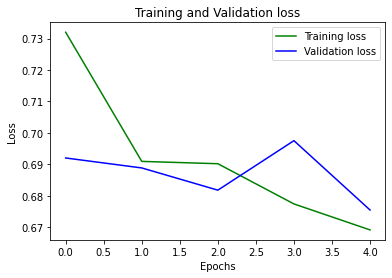

In [ ]:
%matplotlib inline
NUM_EPOCHS=hyperparams['num_epochs']
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

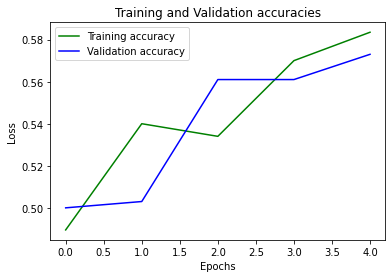

In [ ]:
plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plotting the confusion matrix

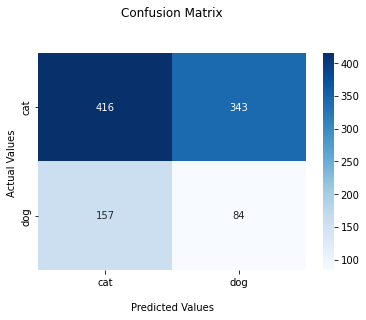

In [ ]:
correct_cats, wrong_cats, correct_dogs, wrong_dogs = compute_confusion_matrix(
    val_predictions,
    val_labels
)
cf_matrix = [
    [correct_cats, wrong_cats],
    [correct_dogs, wrong_dogs]
]
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['cat','dog'])
ax.yaxis.set_ticklabels(['cat','dog'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
cf_matrix

[[416, 343], [157, 84]]

# Part II: Optimizers 

## SGD vs SGD with momentum

|![SGDmomentum](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-28_at_3.25.40_PM_Y687HvA.png)|
|:--:|
| SGD trajectories with and without momentum ([source](https://www.researchgate.net/publication/333469047_The_Frontier_of_SGD_and_Its_Variants_in_Machine_Learning)) |


<!-- $$\theta^{(t+1)} = \theta^{(t)} - α∇_\theta\underbrace{\left(\frac{1}{N}\sum_{i=1}^{N}  L(\theta^{(t)}, x^{(i)})\right)}_\text{loss over all dataset examples}$$ -->

### SGD
$$g^{(t+1)} = \underbrace{∇_\theta L(\theta^{(t)}, x^{(i)})}_\text{current gradient}$$
$$\theta^{(t+1)} = \theta^{(t)} - αg^{(t+1)}$$

### SGD with momentum
$$ g^{(t+1)} = \overbrace{\beta}^\text{momentum factor} \underbrace{g^{(t)}}_\text{past gradients} + \underbrace{∇_\theta L(\theta^{(t)}, x^{(i)})}_\text{current gradient}$$ 

$$\theta^{(t+1)} = \theta^{(t)} - α g^{(t+1)}$$


In [ ]:
class SGD:
    """
    Stochastic Gradient Descent optimizer (2 parameters)
    """
    def __init__(self, params: Iterator[nn.Parameter], lr: float):
        self.w1, self.w2 = list(params)
        self.lr = lr

        # We'll use these two for a plot :)
        if len(self.w1.shape) == 1:
            self.w1_hist = [self.w1.item()]
            self.w2_hist = [self.w2.item()]

    def step(self):
        """
        Perform a gradient decent step. Update the parameters w1 and w2 by using:
          - the gradient of the loss with respect to the parameters
          - the learning rate
        This method is called after backward(), so the gradient of the loss wrt 
        the parameters is already computed and stored.
        """
        with torch.no_grad():
            self.w1 -= self.w1.grad * self.lr
            self.w2 -= self.w2.grad * self.lr

        # We'll use these two for a plot :)
        if len(self.w1.shape) == 1:
            self.w1_hist.append(self.w1.item())
            self.w2_hist.append(self.w2.item())
    
    def zero_grad(self):
        self.w1.grad.zero_()
        self.w2.grad.zero_()

## SGD with momentum (TODO)
Implement SGD with momentum, by writing the `step()` method of the `SGDMomentum` class below:

In [ ]:
class SGDMomentum:
  """
  Stochastic Gradient Descent optimizer (2 parameters) with momentum
  """
  def __init__(self, 
               params: Iterator[nn.Parameter], 
               momentum: float=0.9,
               lr: float=0.1):
    self.w1, self.w2 = list(params)
    self.lr = lr
    self.momentum = momentum
    self.grad_hist_w1 = None # previous gradient for w1
    self.grad_hist_w2 = None # previous gradient for w2

    # We'll use these two for a plot :)
    if len(self.w1.shape) == 1:
      self.w1_hist = [self.w1.item()]
      self.w2_hist = [self.w2.item()]

  def step(self):
    """
    TODO: Perform a gradient decent step with momentum. Update the parameters 
    w1 and w2 by using:
     - the gradient of the loss with respect to the parameters
     - the learning rate
     - the momentum factor
    This method is called after backward(), so the gradient of the loss wrt 
    the parameters is already computed and stored.
    """
    with torch.no_grad():
      # we have computed the gradient before
      if self.grad_hist_w1:
          # TODO: update gradient for w1 and w2 using the momentum equation 
          # (equation for g^t)
          self.grad_hist_w1 = ... 
          self.grad_hist_w2 = ...
          # TODO: update parameters w1 and w2
          self.w1 -= ...
          self.w2 -= ...
      else:
          # TODO: update gradient for w1 and w2 using the momentum equation
          # (it's the first time we compute the gradient, so we save it for
          # future momentum updates)
          self.grad_hist_w1 = ...
          self.grad_hist_w2 = ...
          # TODO: update parameters for w1 and w2
          self.w1 -= ...
          self.w2 -= ...

    # We'll use these two for a plot :)
    if len(self.w1.shape) == 1:
      self.w1_hist.append(self.w1.item())
      self.w2_hist.append(self.w2.item())
  
  def zero_grad(self):
      self.w1.grad.zero_()
      self.w2.grad.zero_()

## Loss landscape visualization
TODO: Try out different functions, change the starting point and learning rate and visualize the optimizers trajectories.

In [ ]:
def mexican(x, y, output='numpy'):
    if output == 'numpy':
        return np.sin(np.sqrt(x ** 2 + y ** 2))
    else:
        return torch.sin(torch.sqrt(x ** 2 + y ** 2))

def δmexican(x, y, output='numpy'):
    if output == 'numpy':
        sq_root = np.sqrt(x**2+y**2)
        dx = x * np.cos(sq_root) / sq_root
        dy = y * np.cos(sq_root) / sq_root
    else:
        sq_root = torch.sqrt(x**2+y**2)
        dx = x * torch.cos(sq_root) / sq_root
        dy = y * torch.cos(sq_root) / sq_root
    return dx, dy

def three_hump_camel(x, y):
    return 2*(x**2) - 1.05*(x**4) + (x**6)/6 + x*y + y**2

def δthree_hump_camel(x, y):
    dx = x**5 - 21*(x**3)/5.0 + 4*x + y
    dy = 2*y + x
    return dx, dy

def rosenbrock(x, y):
    a, b = 1, 20
    return (a-x)**2 + b*(y-x**2)**2

def δrosenbrock(x, y):
    a, b = 1, 20
    dx = 2*((2*b)*x**3 - (2*b)*x*y + x - a)
    dy = 2*b*(y-x**2)
    return dx, dy

def saddle(x, y):
    return x*x - y*y

def δsaddle(x, y):
    dx = 2*x
    dy = -2*y
    return dx, dy

def hills(x, y, output="numpy"):
    if output == "numpy":
        return -1 * np.sin(x * x) * np.cos(3 * y * y) * np.exp(
            -(x * y) * (x * y)
        ) - np.exp(-(x + y) * (x + y))
    else:
        return -1 * torch.sin(x * x) * torch.cos(3 * y * y) * torch.exp(
            -(x * y) * (x * y)
        ) - torch.exp(-(x + y) * (x + y))


def δhills(x, y, output="numpy"):
    if output == "numpy":
        dx = (
            2
            * y**2
            * np.cos(3 * y**2)
            * x
            * np.exp(-(x**2) * (y**2))
            * np.sin(x**2)
            - 2 * np.cos(3 * y**2) * x * np.exp(-(x**2) * (y**2)) * np.cos(x**2)
            + 2 * (x + y) * np.exp(-((x + y) ** 2))
        )
        dy = (
            6 * np.sin(x**2) * y * np.exp(-(x**2) * (y**2)) * np.sin(3 * y**2)
            + 2
            * (x**2)
            * np.sin(x * x)
            * y
            * np.exp(-(x**2) * (y**2))
            * np.cos(3 * y**2)
            + 2 * (y + x) * np.exp(-((x + y) ** 2))
        )
    else:
        dx = (
            2
            * y**2
            * torch.cos(3 * y**2)
            * x
            * torch.exp(-(x**2) * y**2)
            * torch.sin(x**2)
            - 2
            * torch.cos(3 * y**2)
            * x
            * torch.exp(-(x**2) * y**2)
            * torch.cos(x**2)
            + 2 * (x + y) * torch.exp(-((x + y) ** 2))
        )
        dy = (
            6
            * torch.sin(x**2)
            * y
            * torch.exp(-(x**2) * (y**2))
            * torch.sin(3 * y**2)
            + 2
            * (x**2)
            * torch.sin(x * x)
            * y
            * torch.exp(-(x**2) * (y**2))
            * torch.cos(3 * y**2)
            + 2 * (y + x) * torch.exp(-((x + y) ** 2))
        )
    return dx, dy


In [ ]:
class SGD:
    def __init__(self, df, lr, momentum=0):
        self.__lr = lr
        self.__momentum = momentum
        self.__df = df
        self.__vt = None
    
    def __call__(self, x, y):
        if self.__momentum == 0:
            dx, dy = self.__df(x, y)
            x_ = x - self.__lr * dx
            y_ = y - self.__lr * dy
            return x_, y_
        else:
            if self.__vt is None:
                self.__vt = self.__lr * np.array(self.__df(x, y))
            else:
                self.__vt = self.__vt * self.__momentum + self.__lr * np.array(self.__df(x, y))
            return list(np.array([x, y]) - self.__vt)

class Adam:
    def __init__(self, df, lr, β1=0.99, β2=0.999):
        self.__lr = lr
        self.__β1 = β1
        self.__β2 = β2
        self.__ϵ = 1e-8
        self.__df = df
        self.__vt = None
        self.__bt = None

    def __call__(self, x, y):
        gt = np.array(self.__df(x, y))
        if self.__vt is None:
            self.__vt = np.zeros_like(gt)
            self.__mt = np.zeros_like(gt)

        self.__mt = self.__mt * self.__β1 + (1-self.__β1) * gt
        self.__vt = self.__vt * self.__β2 + (1-self.__β2) * gt**2

        mt_hat = self.__mt / (1 - self.__β1)
        vt_hat = self.__vt / (1 - self.__β2)
        
        return list(np.array([x, y]) - (self.__lr * mt_hat) / (np.sqrt(vt_hat) + self.__ϵ))

In [ ]:
"""
For each function we define:
  - a gradient (df)
  - a plotting [x,y] area (interval)
  - a minima (fmin)
  - a starting point (fstart)
"""
functions = {
    "saddle": {
        "f": saddle,
        "df": δsaddle,
        "interval": ((-4.5, 4.5), (-4.5, 4.5)),
        "fmin": (0,-4.5),
        "fstart": (-3.7, -1.5)
    },
    "mexican": {
        "f": mexican,
        "df": δmexican,
        "interval": ((-2, 2), (-1, 3)),
        "fmin": (0, 0),
        "fstart": (-0.9, 0.7)
    },
    "three_hump_camel": {
        "f": three_hump_camel,
        "df": δthree_hump_camel,
        "interval": ((-2, 2), (-2, 2)),
        "fmin": (0, 0),
        "fstart": (1.9, 1.9)
    },
    "rosenbrock": {
        "f": rosenbrock,
        "df": δrosenbrock,
        "interval": ((-2,2), (-1, 3)),
        "fmin": (1, 1),
        "fstart": (0, 0)
    },
    "hills": {
        "f": hills,
        "df": δhills,
        "interval": ((-2,2), (-1, 3)),
        "fmin": (1, 1),
        "fstart": (-1.0, 2.5)
    }
}

In [ ]:
# TODO: modify func_name to play with different functions
func_name = "rosenbrock"
f_configs = functions[func_name]
f  = f_configs["f"]
df = f_configs["df"]
interval = f_configs["interval"]
f_min = f_configs["fmin"]
f_start = f_configs["fstart"]

# we instantiate the optimizers
optims = [
    {'name': 'sgd','optim': SGD(df=df, lr=0.01, momentum=0), 'color':'y'},
    {'name': 'momentum','optim': SGD(df=df, lr=0.01, momentum=0.85), 'color':'m'},
    {'name': 'adam','optim': Adam(df=df, lr=0.01, β1=0.9, β2=0.999), 'color':'g'}
]

# plotting function surface
steps = 100
x = np.linspace(*interval[0], 30)
y = np.linspace(*interval[1], 30)
x_mesh, y_mesh = np.meshgrid(x, y)
z_mesh = f(x_mesh, y_mesh)

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')

ax.plot_surface(x_mesh, y_mesh, z_mesh,
                alpha=.8, rstride=1, cstride=1,
                cmap=cm.coolwarm, edgecolor='none')
ax.scatter(*f_min, f(*f_min), s=100, label='global_min', color='r')

ax.view_init(elev=55, azim=-78)

# draw initial points for each optimizer 
x0, y0 = f_start
z0 = f(x0, y0)

global _x, _y, _z
_x, _y, _z = [x0 for _ in optims], [y0 for _ in optims], [z0 for _ in optims]

# set up artists for the legend
# we will use the tips of each optimizer's trajectories for this
tips = [None] * len(optims)
for oix, optim in enumerate(optims):
    tips[oix] = ax.scatter(
        x0, y0, z0, s=20, 
        depthshade=True, label=optim['name'], color=optim['color']
    )
ax.legend(tips, [o['name'] for o in optims])

<IPython.core.display.Javascript object>

In [ ]:
# this function is called for each optimization step update
def frame(w):
    #ax.clear()
    global _x,_y,_z

    for oix, optim in enumerate(optims):
    
        x, y = optim['optim'](_x[oix], _y[oix])
        z = f(x, y)
        
        # plot the trajectory
        plot = ax.plot(
            [_x[oix], x],
            [_y[oix], y],
            [_z[oix], z],
            linewidth=2, color=optim['color'], alpha=1, zorder=10
        )
        
        # update and plot the tip of the trajectoy
        tips[oix].remove()
        tips[oix] = ax.scatter(
            x, y, z, 
            s=20, label=optim['name'], color=optim['color'],
            alpha=1, zorder=10, depthshade=False
        )

        _x[oix] = x 
        _y[oix] = y 
        _z[oix] = z
    return plot

In [ ]:
def frame(w):
    #ax.clear()
    global _x,_y,_z

    for oix, optim in enumerate(optims):
    
        x, y = optim['optim'](_x[oix], _y[oix])
        z = f(x, y)
        
        # plot the trajectory
        plot = ax.plot(
            [_x[oix], x],
            [_y[oix], y], 
            [_z[oix], z], 
            linewidth=2, color=optim['color'], alpha=1, zorder=10
        )
        
        # update and plot the tip of the trajectoy
        tips[oix].remove()
        tips[oix] = ax.scatter(
            x, y, z, 
            s=20, label=optim['name'], color=optim['color'],
            alpha=1, zorder=10, depthshade=False
        )

        _x[oix] = x 
        _y[oix] = y 
        _z[oix] = z
    return plot

In [ ]:
anim = animation.FuncAnimation(fig, frame, frames=100, blit=False, repeat=True)
HTML(anim.to_html5_video())

In [ ]:
#@title
# Pytorch code
w1 = nn.Parameter(torch.tensor([0.1]))
w2 = nn.Parameter(torch.tensor([0.1]))
#sgd_mom = SGDMomentum(params=[w1, w2])
sgd_mom = torch.optim.SGD(params=iter([w1, w2]), momentum=0.9, lr=0.1)
for i in range(3):
    z = rosenbrock(w1, w2)
    z = z.squeeze()
    z.backward()
    sgd_mom.step()
    w1, w2 = sgd_mom.parameters()
    print("w1 grad: ", w1.grad)
    print("w2 grad: ", w2.grad)
    sgd_mom.zero_grad()
    #w1 = sgd_mom.w1
    #w2 = sgd_mom.w2
    print("w1 = ", w1)
    print("w2 = ", w1)


In [ ]:
#@title
# Pytorch version
f = rosenbrock

# plot function
steps = 100
interval=((-2,2), (-1, 3))
x = np.linspace(*interval[0], 30)
y = np.linspace(*interval[1], 30)
x_mesh, y_mesh = np.meshgrid(x, y)
z_mesh = f(x_mesh, y_mesh)

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')

ax.plot_surface(x_mesh, y_mesh, z_mesh,
                alpha=.8, rstride=1, cstride=1,
                cmap=cm.coolwarm, edgecolor='none')
ax.view_init(elev=55, azim=-78)

# setup starting point
_x, _y = -0.9, 0.3
_z = f(_x, _y)

# setup optimizer
w1 = nn.Parameter(torch.tensor([_x]))
w2 = nn.Parameter(torch.tensor([_y]))
optimizer = SGDMomentum(params=[w1, w2])

def frame(w):
    #ax.clear()
    global _x,_y,_z

    w1 = optimizer.w1
    w2 = optimizer.w2
    _z = f(w1, w2)
    _z = _z.squeeze()
    _z.backward()
    _z = _z.item()

    # parameters after update
    optimizer.step()
    optimizer.zero_grad()
    x = sgd_mom.w1.item()
    y = sgd_mom.w2.item()
    z = f(x, y)
    print("x = ", x)
    print("y = ", y)
    print("z = ", z)

    plot = ax.plot(
        [_x, x],
        [_y, y],
        [_z, z],
        linewidth=2, color="red", alpha=1, zorder=10
    )
    _x, _y, _z = x, y, z
    return plot

<IPython.core.display.Javascript object>